In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import seaborn as sns
import time

In [ ]:
file_path = 'Groceries_dataset.csv'  
try:
    data = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print(data.head())  
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the path.")


Dataset loaded successfully!
   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk


In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [4]:
data['Transaction_ID'] = data['Member_number'].astype(str) + "_" + data['Date'].dt.strftime('%Y-%m-%d')

In [5]:
transactions = data.groupby('Transaction_ID')['itemDescription'].apply(list).reset_index()

In [6]:
all_items = sorted(set(item for sublist in transactions['itemDescription'] for item in sublist))
all_items

['Instant food products',
 'UHT-milk',
 'abrasive cleaner',
 'artif. sweetener',
 'baby cosmetics',
 'bags',
 'baking powder',
 'bathroom cleaner',
 'beef',
 'berries',
 'beverages',
 'bottled beer',
 'bottled water',
 'brandy',
 'brown bread',
 'butter',
 'butter milk',
 'cake bar',
 'candles',
 'candy',
 'canned beer',
 'canned fish',
 'canned fruit',
 'canned vegetables',
 'cat food',
 'cereals',
 'chewing gum',
 'chicken',
 'chocolate',
 'chocolate marshmallow',
 'citrus fruit',
 'cleaner',
 'cling film/bags',
 'cocoa drinks',
 'coffee',
 'condensed milk',
 'cooking chocolate',
 'cookware',
 'cream',
 'cream cheese ',
 'curd',
 'curd cheese',
 'decalcifier',
 'dental care',
 'dessert',
 'detergent',
 'dish cleaner',
 'dishes',
 'dog food',
 'domestic eggs',
 'female sanitary products',
 'finished products',
 'fish',
 'flour',
 'flower (seeds)',
 'flower soil/fertilizer',
 'frankfurter',
 'frozen chicken',
 'frozen dessert',
 'frozen fish',
 'frozen fruits',
 'frozen meals',
 'froze

In [7]:
basket_encoded = pd.DataFrame(
    [{item: (item in items) for item in all_items} for items in transactions['itemDescription']]
)
basket_encoded

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
start_apriori = time.time()
frequent_itemsets_apriori = apriori(basket_encoded, min_support=0.002, use_colnames=True)
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.1, num_itemsets=None)
end_apriori = time.time()


In [9]:
start_fpgrowth = time.time()
frequent_itemsets_fpgrowth = fpgrowth(basket_encoded, min_support=0.002, use_colnames=True)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.1, num_itemsets=None)
end_fpgrowth = time.time()

In [10]:
frequent_itemsets_apriori.to_csv('frequent_itemsets_apriori.csv', index=False)
rules_apriori.to_csv('rules_apriori.csv', index=False)
frequent_itemsets_fpgrowth.to_csv('frequent_itemsets_fpgrowth.csv', index=False)
rules_fpgrowth.to_csv('rules_fpgrowth.csv', index=False)


In [11]:
print("\nApriori Frequent Itemsets:")
print(frequent_itemsets_apriori.head())
print("\nFP-Growth Frequent Itemsets:")
print(frequent_itemsets_fpgrowth.head())



Apriori Frequent Itemsets:
    support                 itemsets
0  0.004010  (Instant food products)
1  0.021386               (UHT-milk)
2  0.008087          (baking powder)
3  0.033950                   (beef)
4  0.021787                (berries)

FP-Growth Frequent Itemsets:
    support       itemsets
0  0.157923   (whole milk)
1  0.051728       (pastry)
2  0.018780  (salty snack)
3  0.085879       (yogurt)
4  0.060349      (sausage)


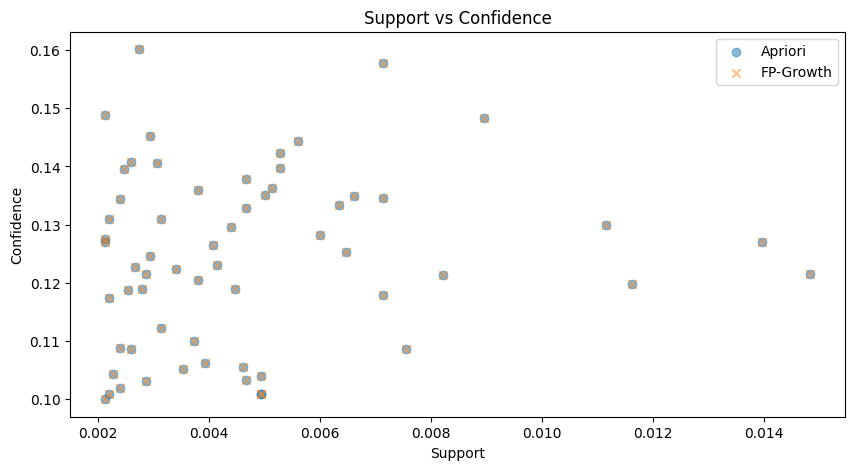

In [12]:
plt.figure(figsize=(10, 5))
plt.scatter(rules_apriori['support'], rules_apriori['confidence'], alpha=0.5, label='Apriori')
plt.scatter(rules_fpgrowth['support'], rules_fpgrowth['confidence'], alpha=0.5, label='FP-Growth', marker='x')
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend()
plt.show()


In [13]:
def predict_transaction_relaxed(new_items, rules):
    predictions = set()
    new_items_set = set(new_items)

    for _, rule in rules.iterrows():
        antecedents = set(rule['antecedents'])
        consequents = set(rule['consequents'])

        if not antecedents.isdisjoint(new_items_set):
            predictions.update(consequents)

    predictions = predictions.difference(new_items_set)
    return predictions


In [14]:
new_transaction = ['chocolate', 'other vegetables']

predicted_items_apriori = predict_transaction_relaxed(new_transaction, rules_apriori)
predicted_items_fpgrowth = predict_transaction_relaxed(new_transaction, rules_fpgrowth)

print("Predicted items (Apriori):", predicted_items_apriori)
print("Predicted items (FP-Growth):", predicted_items_fpgrowth)

print("\nApriori Association Rules:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))  

print("\nFP-Growth Association Rules:")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15)) 

Predicted items (Apriori): {'rolls/buns', 'whole milk'}
Predicted items (FP-Growth): {'rolls/buns', 'whole milk'}

Apriori Association Rules:
        antecedents         consequents   support  confidence      lift
0        (UHT-milk)  (other vegetables)  0.002139    0.100000  0.818993
1        (UHT-milk)        (whole milk)  0.002540    0.118750  0.751949
2            (beef)        (whole milk)  0.004678    0.137795  0.872548
3         (berries)  (other vegetables)  0.002673    0.122699  1.004899
4         (berries)        (whole milk)  0.002272    0.104294  0.660414
5    (bottled beer)  (other vegetables)  0.004678    0.103245  0.845568
6    (bottled beer)        (whole milk)  0.007151    0.157817  0.999330
7   (bottled water)        (whole milk)  0.007151    0.117841  0.746196
8     (brown bread)        (whole milk)  0.004478    0.119005  0.753566
9          (butter)        (whole milk)  0.004678    0.132827  0.841090
10          (candy)        (whole milk)  0.002139    0.148837  0.9

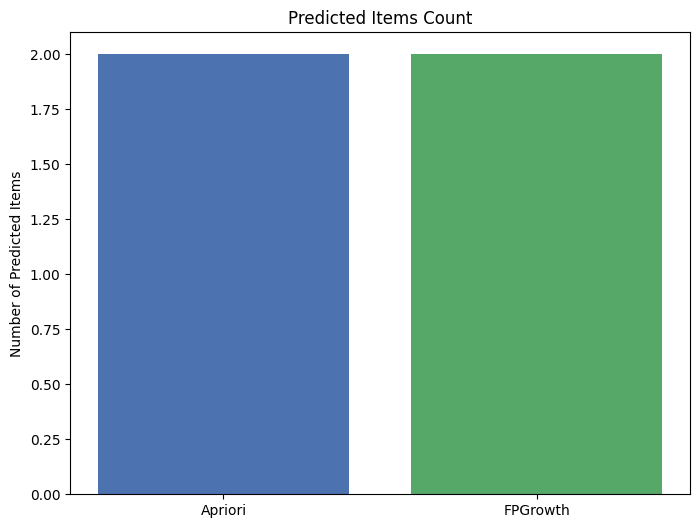

In [15]:
plt.figure(figsize=(8, 6))
labels = ['Apriori', 'FPGrowth']
predictions = [len(predicted_items_apriori), len(predicted_items_fpgrowth)]
plt.bar(labels, predictions, color=['#4C72B0', '#55A868'])
plt.title("Predicted Items Count")
plt.ylabel("Number of Predicted Items")
plt.show()

In [16]:
def calculate_accuracy(predicted_items, actual_items):
    return len(predicted_items & actual_items) / len(actual_items) if actual_items else 0


Execution Time (Apriori): 0.3501 seconds
Execution Time (FP-Growth): 11.2562 seconds
Accuracy (Apriori): 0.50
Accuracy (FP-Growth): 0.50


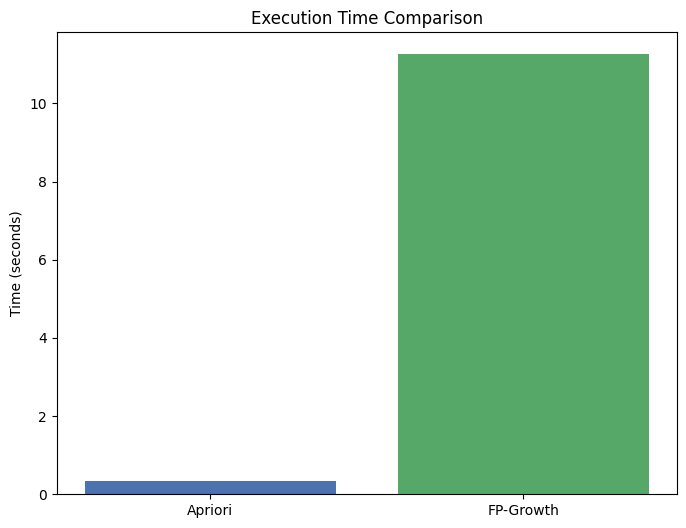

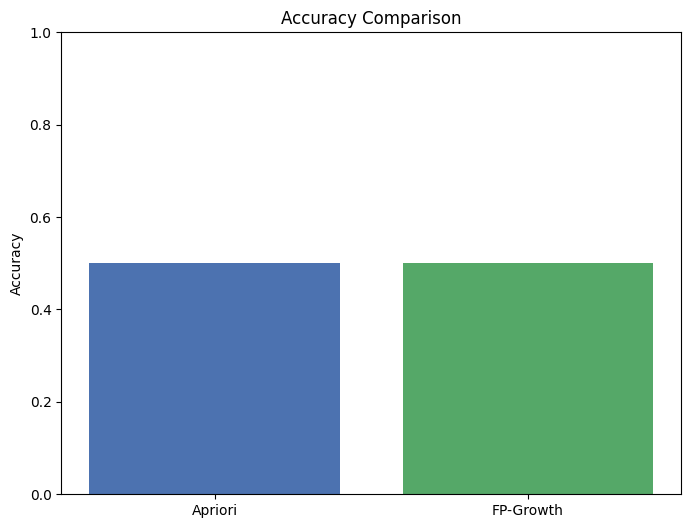

In [ ]:

time_apriori = end_apriori - start_apriori


time_fpgrowth = end_fpgrowth - start_fpgrowth

new_transaction = ['chocolate', 'other vegetables']
actual_items = {'whole milk', 'yogurt'}  

predicted_items_apriori = predict_transaction_relaxed(new_transaction, rules_apriori)
predicted_items_fpgrowth = predict_transaction_relaxed(new_transaction, rules_fpgrowth)

accuracy_apriori = calculate_accuracy(predicted_items_apriori, actual_items)
accuracy_fpgrowth = calculate_accuracy(predicted_items_fpgrowth, actual_items)

print(f"Execution Time (Apriori): {time_apriori:.4f} seconds")
print(f"Execution Time (FP-Growth): {time_fpgrowth:.4f} seconds")
print(f"Accuracy (Apriori): {accuracy_apriori:.2f}")
print(f"Accuracy (FP-Growth): {accuracy_fpgrowth:.2f}")

plt.figure(figsize=(8, 6))
plt.bar(['Apriori', 'FP-Growth'], [time_apriori, time_fpgrowth], color=['#4C72B0', '#55A868'])
plt.title("Execution Time Comparison")
plt.ylabel("Time (seconds)")
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(['Apriori', 'FP-Growth'], [accuracy_apriori, accuracy_fpgrowth], color=['#4C72B0', '#55A868'])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  
plt.show()
